## http://www.cs.toronto.edu/~hinton/absps/tsne.pdf

In [1]:
import numpy as np
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython.display import HTML
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import pandas as pd
sns.set()

In [2]:
df = pd.read_csv('Iris.csv')
Y = df.iloc[:,-1]
df = df.iloc[:,1:-1]
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [3]:
labels = np.unique(Y)
Y = LabelEncoder().fit_transform(Y)

In [4]:
def pca(X, dims=50):
    X = X - np.tile(np.mean(X, 0), (X.shape[0], 1))
    _, eigenvectors = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, eigenvectors[:, :dims])
    return Y

In [5]:
def pairwise_matrix(X):
    sum_square_X = np.sum(np.square(X), 1)
    return (-2 * np.dot(X, X.T) + sum_square_X).T + sum_square_X

In [6]:
def calculate_entropy_and_P(X, variance):
    P = np.exp(-X * variance)
    sum_P = np.sum(P)
    P = P / sum_P
    H = -np.sum(np.log(P) * P)
    return H, P

In [7]:
def calculate_nearest_perplexity(X, toleration=1e-5, perplexity=30,tried=50):
    ori_pairwise = pairwise_matrix(X)
    empty_pairwise = np.zeros((X.shape[0], X.shape[0]))
    sigmas = np.ones((X.shape[0]))
    log_P = np.log(perplexity)
    for i in range(X.shape[0]):
        if (i+1) % 100 == 0:
            print("Computing P-values for point %d of %d" % (i+1, X.shape[0]))
        sigma_min = -np.inf
        sigma_max = np.inf
        pairwise_i = ori_pairwise[i, np.setxor1d(np.arange(X.shape[0]),[i])]
        H, P_pairwise_i = calculate_entropy_and_P(pairwise_i, sigmas[i])
        H_diff = H - log_P
        tries = 0
        while np.abs(H_diff) > toleration and tries < tried:
            if H_diff > 0:
                sigma_min = sigmas[i]
                if sigma_max == np.inf or sigma_max == -np.inf:
                    sigmas[i] *= 2
                else:
                    sigmas[i] = (sigmas[i] + sigma_max) / 2
            else:
                sigma_max = sigmas[i]
                if sigma_min == np.inf or sigma_min == -np.inf:
                    sigmas[i] /= 2
                else:
                    sigmas[i] = (sigmas[i] + sigma_min) / 2
            
            H, P_pairwise_i = calculate_entropy_and_P(pairwise_i, sigmas[i])
            H_diff = H - log_P
            tries += 1
        empty_pairwise[i, np.setxor1d(np.arange(X.shape[0]),[i])] = P_pairwise_i
    return empty_pairwise

In [8]:
def TSNE(X, dimensions=2, pca_dimensions=50, perplexity=30, min_learning_rate=0.001,
         iterations=500, initial_momentum=0.5, final_momentum=0.9):
    X = pca(X, dims=pca_dimensions)
    Y = np.random.randn(X.shape[0], dimensions)
    dY = np.zeros((X.shape[0], dimensions))
    velocity_Y = np.zeros((X.shape[0], dimensions))
    learning_rate = np.zeros((X.shape[0], dimensions))
    pairwise = calculate_nearest_perplexity(X, toleration=1e-5, perplexity=perplexity)
    pairwise = 4 * (pairwise + pairwise.T) / np.sum(pairwise)
    ratio = 500
    for i in range(iterations):
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(X.shape[0]), range(X.shape[0])] = 0
        Q = num / np.sum(num)
        PQ = pairwise - Q
        for n in range(X.shape[0]):
            dY[n, :] = np.sum(np.tile(PQ[:, n] * num[:, n], (dimensions, 1)).T * (Y[n, :] - Y), 0)
        initial_momentum += (initial_momentum / iterations)
        momentum = min(initial_momentum, final_momentum)
        learning_rate = (learning_rate + 0.2) * ((dY > 0.) != (velocity_Y > 0.)) + (learning_rate * 0.8) * ((dY > 0.) == (velocity_Y > 0.))
        learning_rate[learning_rate < min_learning_rate] = min_learning_rate
        velocity_Y = momentum * velocity_Y - ratio * (learning_rate * dY)
        Y = Y + velocity_Y
        Y = Y - np.tile(np.mean(Y, 0), (X.shape[0], 1))
        if i == 100:
            pairwise = pairwise / 4
    return Y

Computing P-values for point 100 of 150


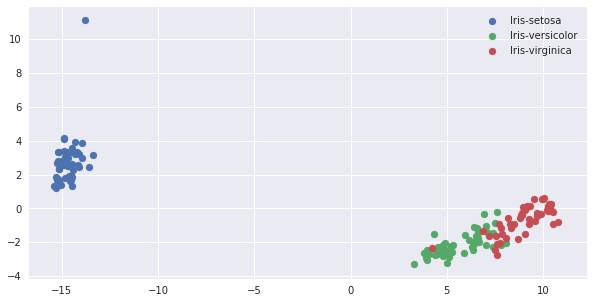

In [9]:
tsne = TSNE(df.values)
plt.figure(figsize=(10,5))
for no, i in enumerate(np.unique(Y)):
    plt.scatter(tsne[Y==i,0], tsne[Y==i,1], label=labels[no])
plt.legend()
plt.show()

Computing P-values for point 100 of 150


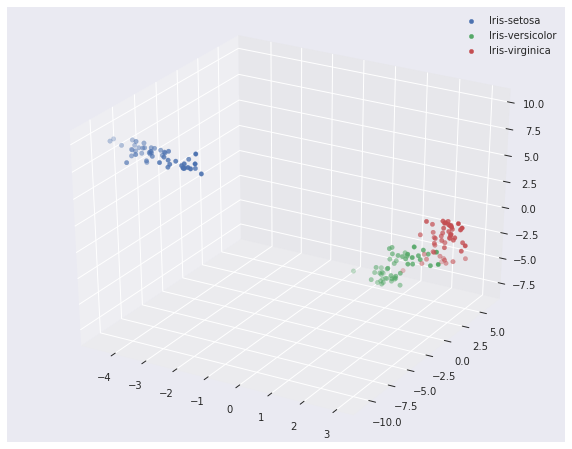

In [10]:
tsne_3d = TSNE(df.values, dimensions=3)
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
for no, i in enumerate(np.unique(Y)):
    ax.scatter(tsne_3d[Y==i,0], tsne_3d[Y==i,1], tsne_3d[Y==i,2], label=labels[no])
plt.legend()
plt.show()

Computing P-values for point 100 of 150


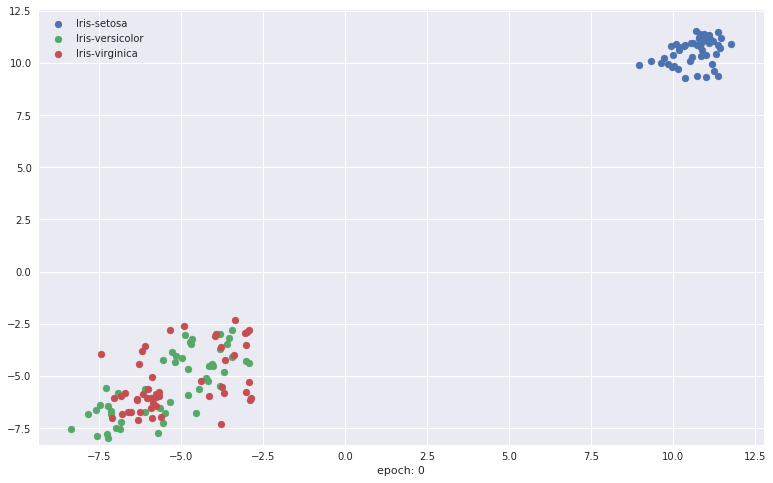

In [14]:
dimensions = 2
ratio = 500
min_learning_rate = 0.001
initial_momentum = 0.5
final_momentum = 0.9
iterations = 300
fig = plt.figure(figsize=(13,8))
ax = plt.axes()
tsne = np.random.randn(df.shape[0], dimensions)
dY = np.zeros((df.shape[0], dimensions))
velocity_Y = np.zeros((df.shape[0], dimensions))
learning_rate = np.zeros((df.shape[0], dimensions))
pairwise = calculate_nearest_perplexity(df.values, toleration=1e-5, perplexity=30)
pairwise = 4 * (pairwise + pairwise.T) / np.sum(pairwise)
scatters = []
min_y, max_y, min_x, max_x = np.min(tsne[:,1])-1, np.max(tsne[:,1])+1,np.min(tsne[:,0])-1, np.max(tsne[:,0])+1
for no, i in enumerate(np.unique(Y)):
    scatters.append(ax.scatter(tsne[Y==i,0], tsne[Y==i,1], label=labels[no]))
ax.legend()
ax.set_xlabel('epoch: %d'%(0))
ax.axis([min_x, max_x, min_y, max_y])
def train_TSNE(epoch):
    global dY, tsne, velocity_Y, pairwise, initial_momentum, learning_rate
    sum_Y = np.sum(np.square(tsne), 1)
    num = -2. * np.dot(tsne, tsne.T)
    num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
    num[range(df.shape[0]), range(df.shape[0])] = 0
    Q = num / np.sum(num)
    PQ = pairwise - Q
    for n in range(df.shape[0]):
        dY[n, :] = np.sum(np.tile(PQ[:, n] * num[:, n], (dimensions, 1)).T * (tsne[n, :] - tsne), 0)
    initial_momentum += (initial_momentum / iterations)
    momentum = min(initial_momentum, final_momentum)
    learning_rate = (learning_rate + 0.2) * ((dY > 0.) != (velocity_Y > 0.)) + (learning_rate * 0.8) * ((dY > 0.) == (velocity_Y > 0.))
    learning_rate[learning_rate < min_learning_rate] = min_learning_rate
    velocity_Y = momentum * velocity_Y - ratio * (learning_rate * dY)
    tsne = tsne + velocity_Y
    tsne = tsne - np.tile(np.mean(tsne, 0), (df.shape[0], 1))
    if epoch == 100:
        pairwise = pairwise / 4
    min_y, max_y, min_x, max_x = np.min(tsne[:,1])-1, np.max(tsne[:,1])+1,np.min(tsne[:,0])-1, np.max(tsne[:,0])+1
    for no, i in enumerate(np.unique(Y)):
        scatters[no].set_offsets([tsne[Y==i,0], tsne[Y==i,1]])
    ax.set_xlabel('epoch: %d'%(epoch))
    ax.axis([min_x, max_x, min_y, max_y])
    return scatters, ax
anim = animation.FuncAnimation(fig, train_TSNE, frames=iterations, interval=200)
anim.save('animation-tsne-iris.gif', writer='imagemagick', fps=10)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


Computing P-values for point 100 of 150
Computing P-values for point 100 of 150
Computing P-values for point 100 of 150
Computing P-values for point 100 of 150
Computing P-values for point 100 of 150
Computing P-values for point 100 of 150
Computing P-values for point 100 of 150
Computing P-values for point 100 of 150
Computing P-values for point 100 of 150
Computing P-values for point 100 of 150
Computing P-values for point 100 of 150
Computing P-values for point 100 of 150
Computing P-values for point 100 of 150
Computing P-values for point 100 of 150
Computing P-values for point 100 of 150
Computing P-values for point 100 of 150
Computing P-values for point 100 of 150
Computing P-values for point 100 of 150
Computing P-values for point 100 of 150
Computing P-values for point 100 of 150
Computing P-values for point 100 of 150
Computing P-values for point 100 of 150
Computing P-values for point 100 of 150
Computing P-values for point 100 of 150
Computing P-values for point 100 of 150


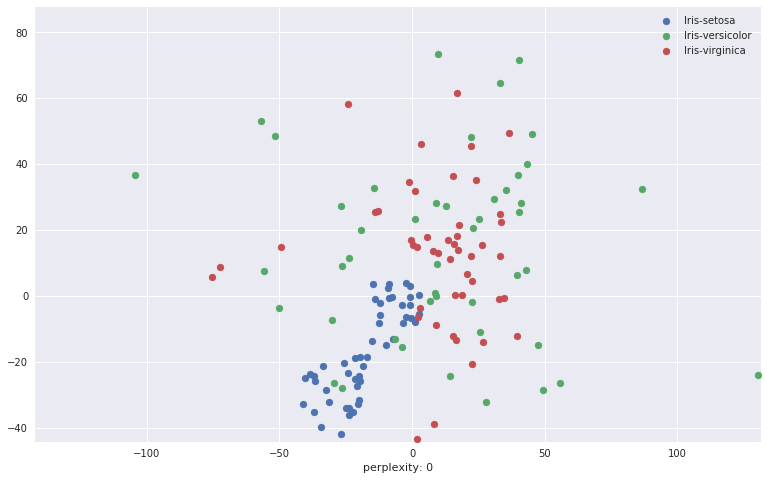

In [18]:
dimensions=2
pca_dimensions=50
min_learning_rate=0.001
iterations=500
fig = plt.figure(figsize=(13,8))
ax = plt.axes()
tsne = np.random.randn(df.shape[0], dimensions)
scatters = []
min_y, max_y, min_x, max_x = np.min(tsne[:,1])-1, np.max(tsne[:,1])+1,np.min(tsne[:,0])-1, np.max(tsne[:,0])+1
for no, i in enumerate(np.unique(Y)):
    scatters.append(ax.scatter(tsne[Y==i,0], tsne[Y==i,1], label=labels[no]))
ax.legend()
ax.set_xlabel('perplexity: %d'%(0))
ax.axis([min_x, max_x, min_y, max_y])
def train_TSNE_perplexity(epoch):
    initial_momentum=0.5
    final_momentum=0.9
    X = pca(df, dims=pca_dimensions)
    tsne = np.random.randn(X.shape[0], dimensions)
    dY = np.zeros((X.shape[0], dimensions))
    velocity_Y = np.zeros((X.shape[0], dimensions))
    learning_rate = np.zeros((X.shape[0], dimensions))
    pairwise = calculate_nearest_perplexity(X, toleration=1e-5, perplexity=epoch)
    pairwise = 4 * (pairwise + pairwise.T) / np.sum(pairwise)
    ratio = 500
    for i in range(iterations):
        sum_Y = np.sum(np.square(tsne), 1)
        num = -2. * np.dot(tsne, tsne.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(X.shape[0]), range(X.shape[0])] = 0
        Q = num / np.sum(num)
        PQ = pairwise - Q
        for n in range(X.shape[0]):
            dY[n, :] = np.sum(np.tile(PQ[:, n] * num[:, n], (dimensions, 1)).T * (tsne[n, :] - tsne), 0)
        initial_momentum += (initial_momentum / iterations)
        momentum = min(initial_momentum, final_momentum)
        learning_rate = (learning_rate + 0.2) * ((dY > 0.) != (velocity_Y > 0.)) + (learning_rate * 0.8) * ((dY > 0.) == (velocity_Y > 0.))
        learning_rate[learning_rate < min_learning_rate] = min_learning_rate
        velocity_Y = momentum * velocity_Y - ratio * (learning_rate * dY)
        tsne = tsne + velocity_Y
        tsne = tsne - np.tile(np.mean(tsne, 0), (X.shape[0], 1))
        if i == 100:
            pairwise = pairwise / 4
    min_y, max_y, min_x, max_x = np.min(tsne[:,1])-1, np.max(tsne[:,1])+1,np.min(tsne[:,0])-1, np.max(tsne[:,0])+1
    for no, i in enumerate(np.unique(Y)):
        scatters[no].set_offsets([tsne[Y==i,0], tsne[Y==i,1]])
    ax.set_xlabel('perplexity: %d'%(epoch))
    ax.axis([min_x, max_x, min_y, max_y])
    return scatters, ax
anim = animation.FuncAnimation(fig, train_TSNE_perplexity, frames=100, interval=200)
anim.save('animation-tsne-perplexity-iris.gif', writer='imagemagick', fps=10)